# Preprocessing Data Train_CSV



In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Summarizer_AI/Dataset/canonical_csv/train.csv')

In [ ]:
train_df.iloc[1]

,1
id,116936
url,https://www.liputan6.com/news/read/116936/-i-n...
article,"Liputan6. com, Jakarta: Earth Wind and Fire Ex..."
summary,"Setelah di Bandung, Earth Wind and Fire gilira..."


In [ ]:
train_df = train_df.drop(['id', 'url'], axis=1)

In [ ]:
train_df = train_df.rename(columns={"article": "original_text"})
train_df = train_df.rename(columns={"summary": "abstractive_summary"})

In [ ]:
train_df.shape

(193883, 2)

In [ ]:
import re

def clean_text(text):
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove URL + lowercase
    text = re.sub(r'#(\w+)', lambda match: ' ' + re.sub(r'(?<=[a-z0-9])(?=[A-Z])', ' ', match.group(1)), text)
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)


    return text

train_df['original_text'] = train_df['original_text'].apply(clean_text)
train_df['abstractive_summary'] = train_df['abstractive_summary'].apply(clean_text)

In [ ]:
train_df.head()

,original_text,abstractive_summary
0,tiga kali somasi dilayangkan kepada nuri shade...,tiga kali somasi dilayangkan kepada nuri shade...
1,liputan6 com jakarta earth wind and fire ex...,setelah di bandung earth wind and fire gilira...
2,liputan6 com jakarta belasan unit mobil pem...,lokasi kebakaran di rumah bernomor sembilan di...
3,empat tahun silam ballack terpaksa duduk di b...,dua kali michael ballack berjuang di pd dua k...
4,liputan6 com bandung ruthini anggota pondo...,sekitar 260 an pengikut mangapin sibuea itu be...


# Alasan menggunakan metode IQR (Remove Outlier)

In [ ]:
import numpy as np
from scipy import stats

def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].apply(len)))
    return df[z_scores < threshold]

def remove_outliers_std(df, column, n_std=2):
    mean_length = df[column].apply(len).mean()
    std_length = df[column].apply(len).std()

    return df[
        (df[column].apply(len) >= mean_length - n_std * std_length) &
        (df[column].apply(len) <= mean_length + n_std * std_length)
    ]

def compare_outlier_removal_methods(df, column):
    # Hitung IQR
    Q1 = df[column].apply(len).quantile(0.25)
    Q3 = df[column].apply(len).quantile(0.75)
    IQR = Q3 - Q1

    methods = {
        'IQR Method': len(df) - len(df[
            (df[column].apply(len) >= Q1 - 1.5 * IQR) &
            (df[column].apply(len) <= Q3 + 1.5 * IQR)
        ]),
        'Z-Score Method': len(df) - len(remove_outliers_zscore(df, column)),
        'Percentile Method': len(df) - len(df[
            (df[column].apply(len) >= df[column].apply(len).quantile(0.01)) &
            (df[column].apply(len) <= df[column].apply(len).quantile(0.99))
        ]),
        'Standard Deviation': len(df) - len(remove_outliers_std(df, column)),
        'Absolute Threshold (10-1000)': len(df) - len(df[
            (df[column].apply(len) >= 10) &
            (df[column].apply(len) <= 1000)
        ])
    }

    return methods

outliers_count = compare_outlier_removal_methods(train_df, 'original_text')
print("\nPerbandingan Metode Removal Outliers:")
for method, count in outliers_count.items():
    print(f"{method}: {count} outliers ({count/len(train_df)*100:.2f}%)")


Perbandingan Metode Removal Outliers:
IQR Method: 9130 outliers (4.71%)
Z-Score Method: 2927 outliers (1.51%)
Percentile Method: 3860 outliers (1.99%)
Standard Deviation: 6626 outliers (3.42%)
Absolute Threshold (10-1000): 126246 outliers (65.11%)


Statistik Panjang Teks:
Mean: 1411.85
Median: 1187.00
Std Dev: 847.79
Min: 231
Max: 47146


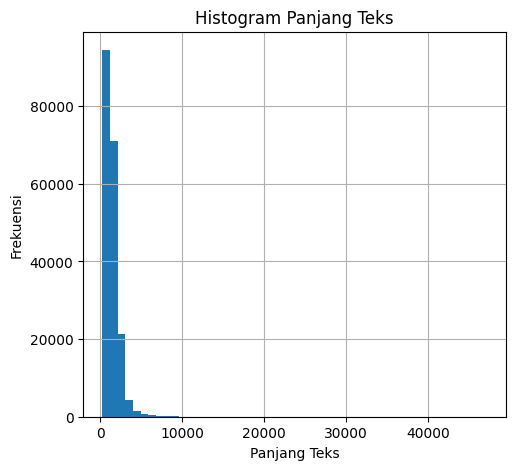

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

text_lengths = train_df['original_text'].apply(len)
print("Statistik Panjang Teks:")
print(f"Mean: {text_lengths.mean():.2f}")
print(f"Median: {text_lengths.median():.2f}")
print(f"Std Dev: {text_lengths.std():.2f}")
print(f"Min: {text_lengths.min()}")
print(f"Max: {text_lengths.max()}")

plt.figure(figsize=(12,5))
plt.subplot(121)
text_lengths.hist(bins=50)
plt.title('Histogram Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.show()

# Mengambil 40k data sampel dan melakukan remove outlier pada train_csv



In [ ]:
sample_train_df = train_df.sample(n=40000, random_state=42)
sample_train_df.shape

(40000, 2)

In [ ]:
sample_train_df.head()

,original_text,abstractive_summary
42855,liputan6 com jakarta jennifer arnelita data...,jennifer arnelita menjadi sutradara dalam peng...
136345,liputan6 com jakarta abu bakar ba asyir tid...,terdakwa kasus terorisme ustad abu bakar ba as...
88528,liputan6 com jakarta menteri negara pembang...,menteri negara pembangunan nasional kwik kian ...
85788,liputan6 com garut ratusan warga dari berba...,ratusan warga dari berbagai ormas islam berunj...
42360,liputan6 com jakarta mantan ketua kssk sri ...,mantan ketua kssk sri mulyani mengaku ditanya ...


In [ ]:
def count_words(text):
    return len(str(text).split())

In [ ]:
def calculate_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

Original shape: (40000, 4)
Shape after removing outliers: (36365, 2)
Number of outliers removed: 3635


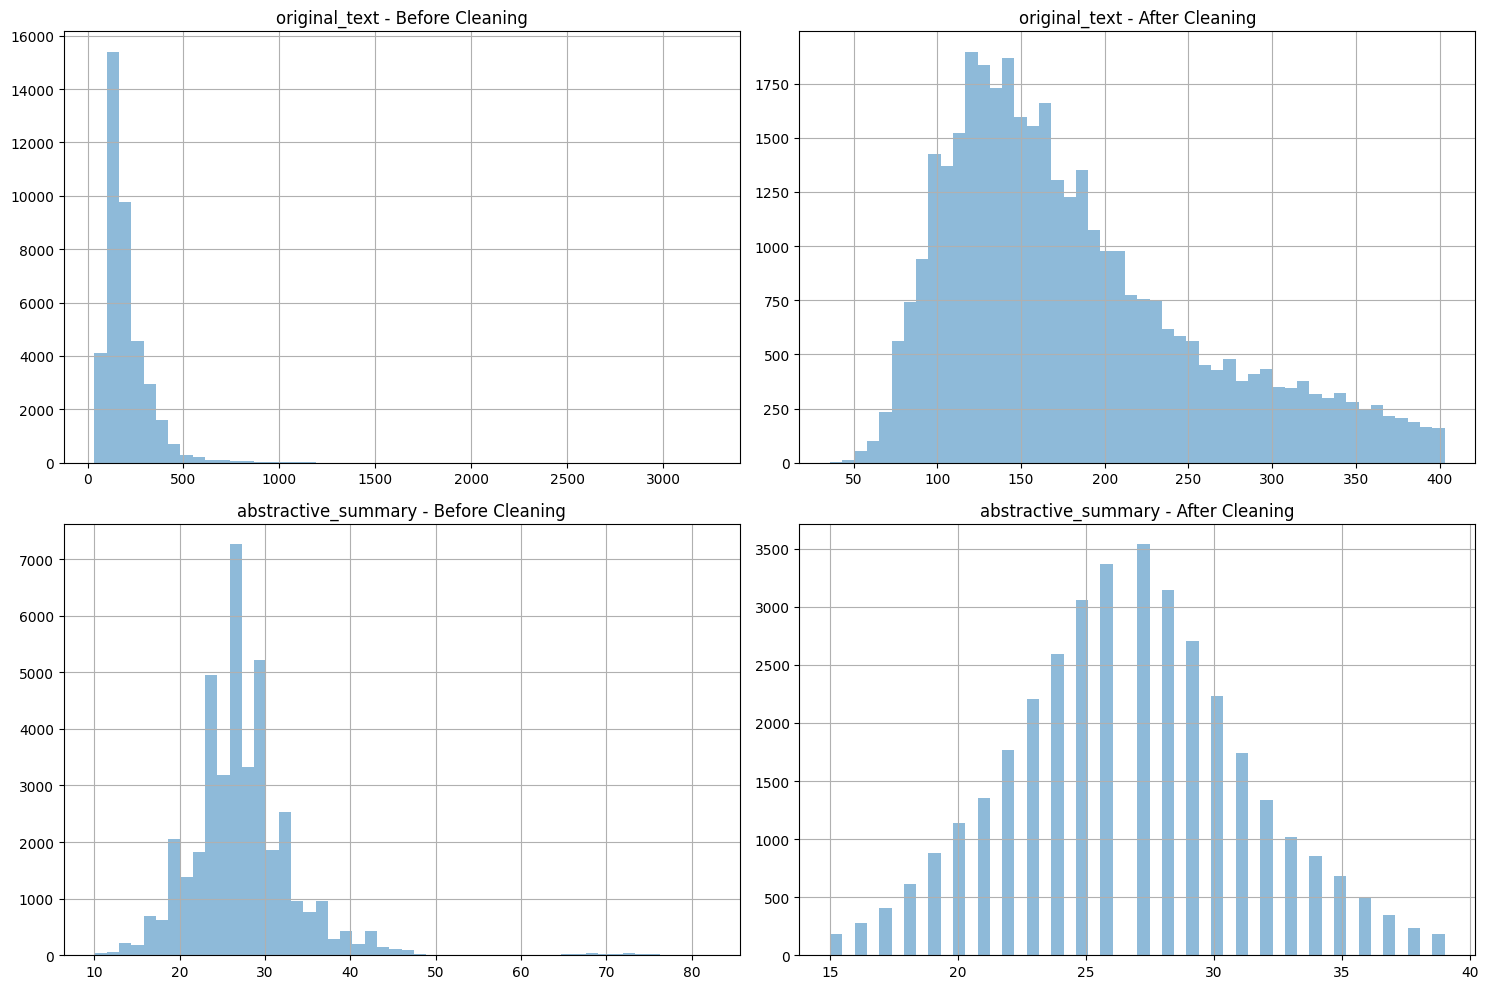

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def find_and_remove_outliers(df, columns):
    """
    Find and remove outliers from specified columns based on word count

    Parameters:
    df (pandas.DataFrame): Input dataframe
    columns (list): List of column names to check for outliers

    Returns:
    tuple: (cleaned_df, outliers_df)
    """
    # Add word count columns
    for col in columns:
        df[f'{col}_words'] = df[col].apply(count_words)

    # Calculate bounds for each column
    bounds = {}
    for col in columns:
        bounds[col] = calculate_outlier_bounds(df[f'{col}_words'])

    # Create mask for valid rows
    mask = pd.Series(True, index=df.index)
    for col in columns:
        lower, upper = bounds[col]
        mask &= df[f'{col}_words'].between(lower, upper)

    # Split into clean data and outliers
    clean_df = df[mask].copy()
    outliers_df = df[~mask].copy()

    # Remove temporary word count columns
    for col in columns:
        clean_df.drop(f'{col}_words', axis=1, inplace=True)
        outliers_df.drop(f'{col}_words', axis=1, inplace=True)

    return clean_df, outliers_df

# Penggunaan
columns_to_check = ['original_text', 'abstractive_summary']
clean_sample_train_df, outliers = find_and_remove_outliers(sample_train_df, columns_to_check)

# Print results
print(f"Original shape: {sample_train_df.shape}")
print(f"Shape after removing outliers: {clean_sample_train_df.shape}")
print(f"Number of outliers removed: {len(outliers)}")

# Optional: Visualisasi distribusi sebelum dan sesudah
def plot_word_distributions(original_df, cleaned_df, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(15, 5*len(columns)))

    for i, col in enumerate(columns):
        # Before cleaning
        original_df[col].apply(count_words).hist(
            ax=axes[i,0], bins=50, alpha=0.5
        )
        axes[i,0].set_title(f'{col} - Before Cleaning')

        # After cleaning
        cleaned_df[col].apply(count_words).hist(
            ax=axes[i,1], bins=50, alpha=0.5
        )
        axes[i,1].set_title(f'{col} - After Cleaning')

    plt.tight_layout()
    plt.show()

# Plot distributions
plot_word_distributions(sample_train_df, clean_sample_train_df, columns_to_check)

In [ ]:
from google.colab import files

clean_sample_train_df.to_csv('train_df.csv', encoding = 'utf-8-sig')
files.download('train_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preprocessing Data Dev_CSV

In [ ]:
dev_df = pd.read_csv('/content/drive/MyDrive/Summarizer_AI/Dataset/canonical_csv/dev.csv')

In [ ]:
dev_df.iloc[1]

,1
id,2833
url,https://www.liputan6.com/news/read/2833/pajak-...
article,"Liputan6. com, Jakarta: Gubernur DKI Jakarta S..."
summary,Pendapatan Asli Daerah Jakarta kerap terkumpul...


In [ ]:
dev_df = dev_df.drop(['id', 'url'], axis=1)

In [ ]:
dev_df = dev_df.rename(columns={"article": "original_text"})
dev_df = dev_df.rename(columns={"summary": "abstractive_summary"})

In [ ]:
dev_df.shape

(10972, 2)

In [ ]:
import re

def clean_text(text):
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove URL + lowercase
    text = re.sub(r'#(\w+)', lambda match: ' ' + re.sub(r'(?<=[a-z0-9])(?=[A-Z])', ' ', match.group(1)), text)
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)


    return text

dev_df['original_text'] = dev_df['original_text'].apply(clean_text)
dev_df['abstractive_summary'] = dev_df['abstractive_summary'].apply(clean_text)

In [ ]:
dev_df.head()

,article,summary
0,"Liputan6. com, Jakarta: Keinginan untuk menind...",Sebagian anggota DPR berniat besar menindaklan...
1,"Liputan6. com, Jakarta: Gubernur DKI Jakarta S...",Pendapatan Asli Daerah Jakarta kerap terkumpul...
2,"Liputan6. com, Jakarta: Sejumlah mobil yang te...",Sejumlah mobil yang terjebak di BEJ sudah mula...
3,"Liputan6. com, Medan: Kepolisian Daerah Sumate...",Polda Sumatra Utara menahan tiga tersangka per...
4,"Liputan6. com, Jakarta: Ratusan mobil selundup...",Bea dan Cukai Jakarta akan melelang ratusan mo...


# Mengambil 4K data sampel dev dan melakukan remove outlier pada dev_csv

In [ ]:
sample_dev_df = dev_df.sample(n=4000, random_state=42)
sample_dev_df.shape

(4000, 2)

In [ ]:
sample_dev_df.head()

,original_text,abstractive_summary
6475,liputan6 com maluku gereja protestan di mal...,untuk menciptakan perdamaian di maluku gereja...
9607,liputan6 com jakarta kejaksaan agung tak me...,mantan direktur utama pln zuhal diperiksa tim ...
9470,liputan6 com jakarta tidur jaksa agung marz...,jaksa agung marzuki darusman dinilai gagal men...
360,liputan6 com jakarta panglima tni laksamana...,panglima tni widodo as menyatakan tentara sia...
1807,liputan6 com banten gelombang air di selat ...,jadwal keberangkatan dan kedatangan di pelabuh...


In [ ]:
def count_words(text):
    return len(str(text).split())

In [ ]:
def calculate_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

Original shape: (4000, 4)
Shape after removing outliers: (3624, 2)
Number of outliers removed: 376


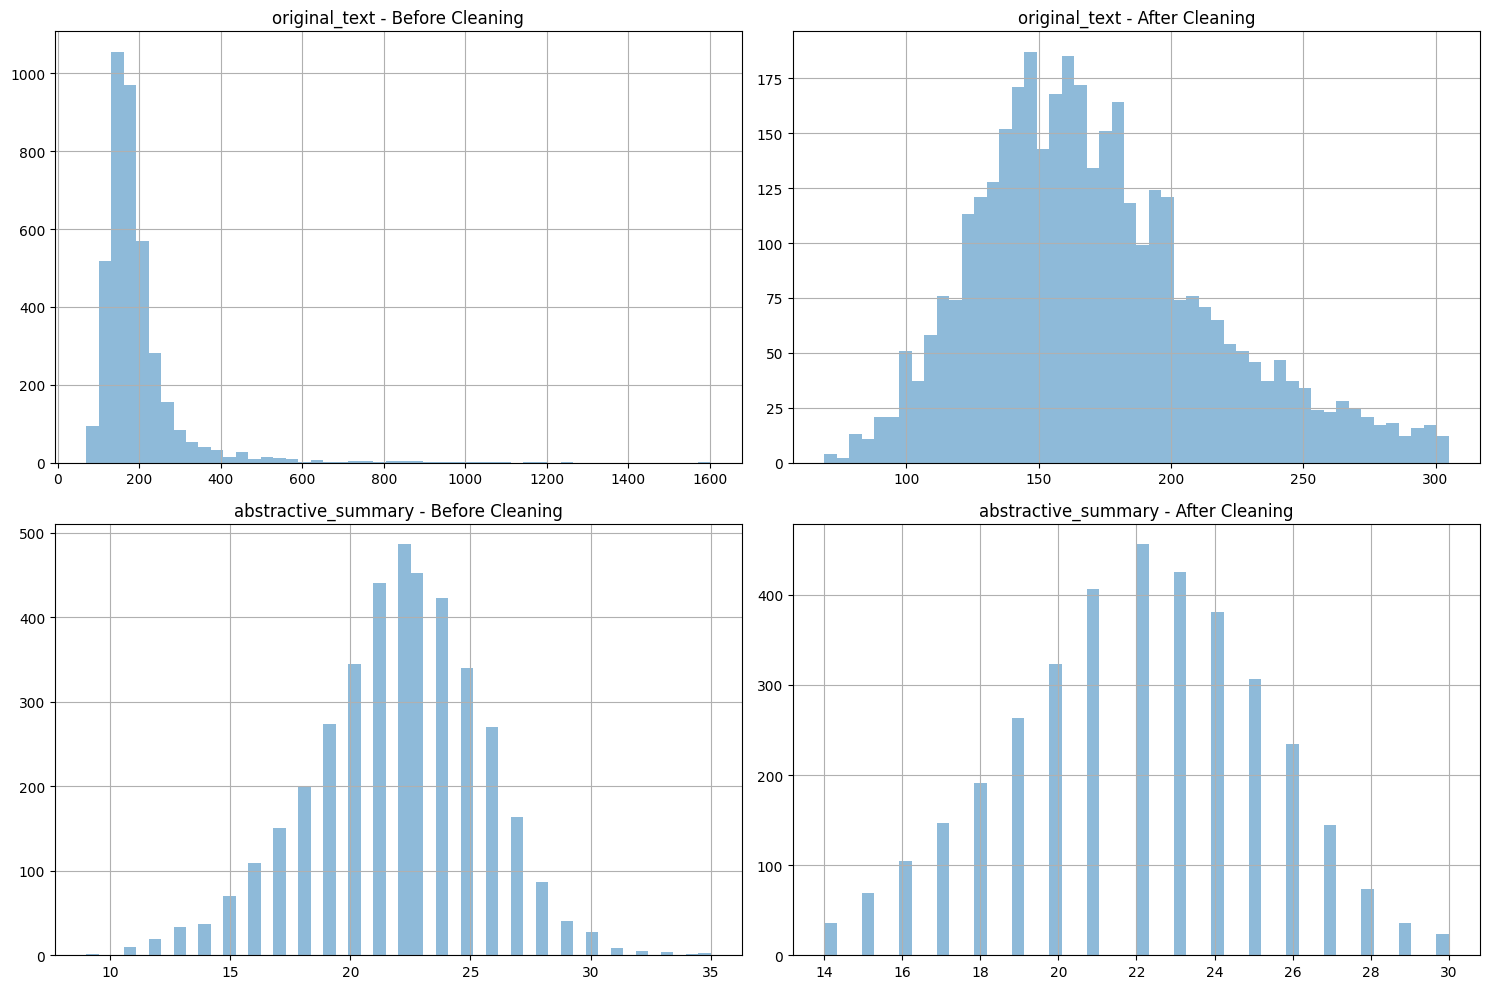

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def find_and_remove_outliers(df, columns):
    """
    Find and remove outliers from specified columns based on word count

    Parameters:
    df (pandas.DataFrame): Input dataframe
    columns (list): List of column names to check for outliers

    Returns:
    tuple: (cleaned_df, outliers_df)
    """
    # Add word count columns
    for col in columns:
        df[f'{col}_words'] = df[col].apply(count_words)

    # Calculate bounds for each column
    bounds = {}
    for col in columns:
        bounds[col] = calculate_outlier_bounds(df[f'{col}_words'])

    # Create mask for valid rows
    mask = pd.Series(True, index=df.index)
    for col in columns:
        lower, upper = bounds[col]
        mask &= df[f'{col}_words'].between(lower, upper)

    # Split into clean data and outliers
    clean_df = df[mask].copy()
    outliers_df = df[~mask].copy()

    # Remove temporary word count columns
    for col in columns:
        clean_df.drop(f'{col}_words', axis=1, inplace=True)
        outliers_df.drop(f'{col}_words', axis=1, inplace=True)

    return clean_df, outliers_df

# Penggunaan
columns_to_check = ['original_text', 'abstractive_summary']
clean_sample_raw_df, outliers = find_and_remove_outliers(sample_dev_df, columns_to_check)

# Print results
print(f"Original shape: {sample_dev_df.shape}")
print(f"Shape after removing outliers: {clean_sample_raw_df.shape}")
print(f"Number of outliers removed: {len(outliers)}")

# Optional: Visualisasi distribusi sebelum dan sesudah
def plot_word_distributions(original_df, cleaned_df, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(15, 5*len(columns)))

    for i, col in enumerate(columns):
        # Before cleaning
        original_df[col].apply(count_words).hist(
            ax=axes[i,0], bins=50, alpha=0.5
        )
        axes[i,0].set_title(f'{col} - Before Cleaning')

        # After cleaning
        cleaned_df[col].apply(count_words).hist(
            ax=axes[i,1], bins=50, alpha=0.5
        )
        axes[i,1].set_title(f'{col} - After Cleaning')

    plt.tight_layout()
    plt.show()

# Plot distributions
plot_word_distributions(sample_dev_df, clean_sample_raw_df, columns_to_check)

In [ ]:
from google.colab import files

clean_sample_raw_df.to_csv('dev_df.csv', encoding = 'utf-8-sig')
files.download('dev_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preprocessing Data Test_CSV

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Summarizer_AI/Dataset/canonical_csv/test.csv')

In [ ]:
test_df.iloc[1]

,1
id,24141
url,https://www.liputan6.com/news/read/24141/busun...
article,"Liputan6. com, Bandar Lampung: Sebanyak 51 ana..."
summary,Sebanyak 51 anak di bawah usia lima tahun di K...


In [ ]:
test_df = test_df.drop(['id', 'url'], axis=1)

In [ ]:
test_df = test_df.rename(columns={"article": "original_text"})
test_df = test_df.rename(columns={"summary": "abstractive_summary"})

In [ ]:
test_df.shape

(10972, 2)

In [ ]:
import re

def clean_text(text):
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove URL + lowercase
    text = re.sub(r'#(\w+)', lambda match: ' ' + re.sub(r'(?<=[a-z0-9])(?=[A-Z])', ' ', match.group(1)), text)
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)


    return text

test_df['original_text'] = test_df['original_text'].apply(clean_text)
test_df['abstractive_summary'] = test_df['abstractive_summary'].apply(clean_text)

In [ ]:
test_df.head()

,original_text,abstractive_summary
0,liputan6 com bangka kapal patroli angkatan ...,meski memiliki izin resmi tni al tetap menang...
1,liputan6 com bandar lampung sebanyak 51 ana...,sebanyak 51 anak di bawah usia lima tahun di k...
2,liputan6 com jakarta polemik seputar pelaks...,presiden abdurrahman wahid kembali mengeluarka...
3,liputan6 com ambon bahan bakar minyak jenis...,sepekan terakhir bahan bakar minyak jenis sol...
4,liputan6 com jakarta seluruh perubahan pasa...,bank indonesia menyerahkan sepenuhnya amendeme...


# Mengambil 4K data sampel test dan melakukan remove outlier pada test_csv

In [ ]:
sample_test_df = test_df.sample(n=4000, random_state=42)
sample_test_df.shape

(4000, 2)

In [ ]:
sample_test_df.head()

,original_text,abstractive_summary
6475,liputan6 com jakarta kejatuhan abdurrahman ...,bekas presiden abdurrahman wahid tumbang lanta...
9607,liputan6 com jakarta mantan presiden abdurr...,mantan presiden abdurrahman wahid mengatakan s...
9470,liputan6 com jakarta bank muamalat bergemin...,bank muamalat akan meningkatkan jumlah kreditn...
360,liputan6 com jakarta secara keseluruhan law...,secara keseluruhan lawatan megawati ke as dan ...
1807,liputan6 com jakarta tanah makam baharuddin...,ahmad ali marsilam simanjuntak artidjo alkos...


In [ ]:
def count_words(text):
    return len(str(text).split())

In [ ]:
def calculate_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

Original shape: (4000, 4)
Shape after removing outliers: (3738, 2)
Number of outliers removed: 262


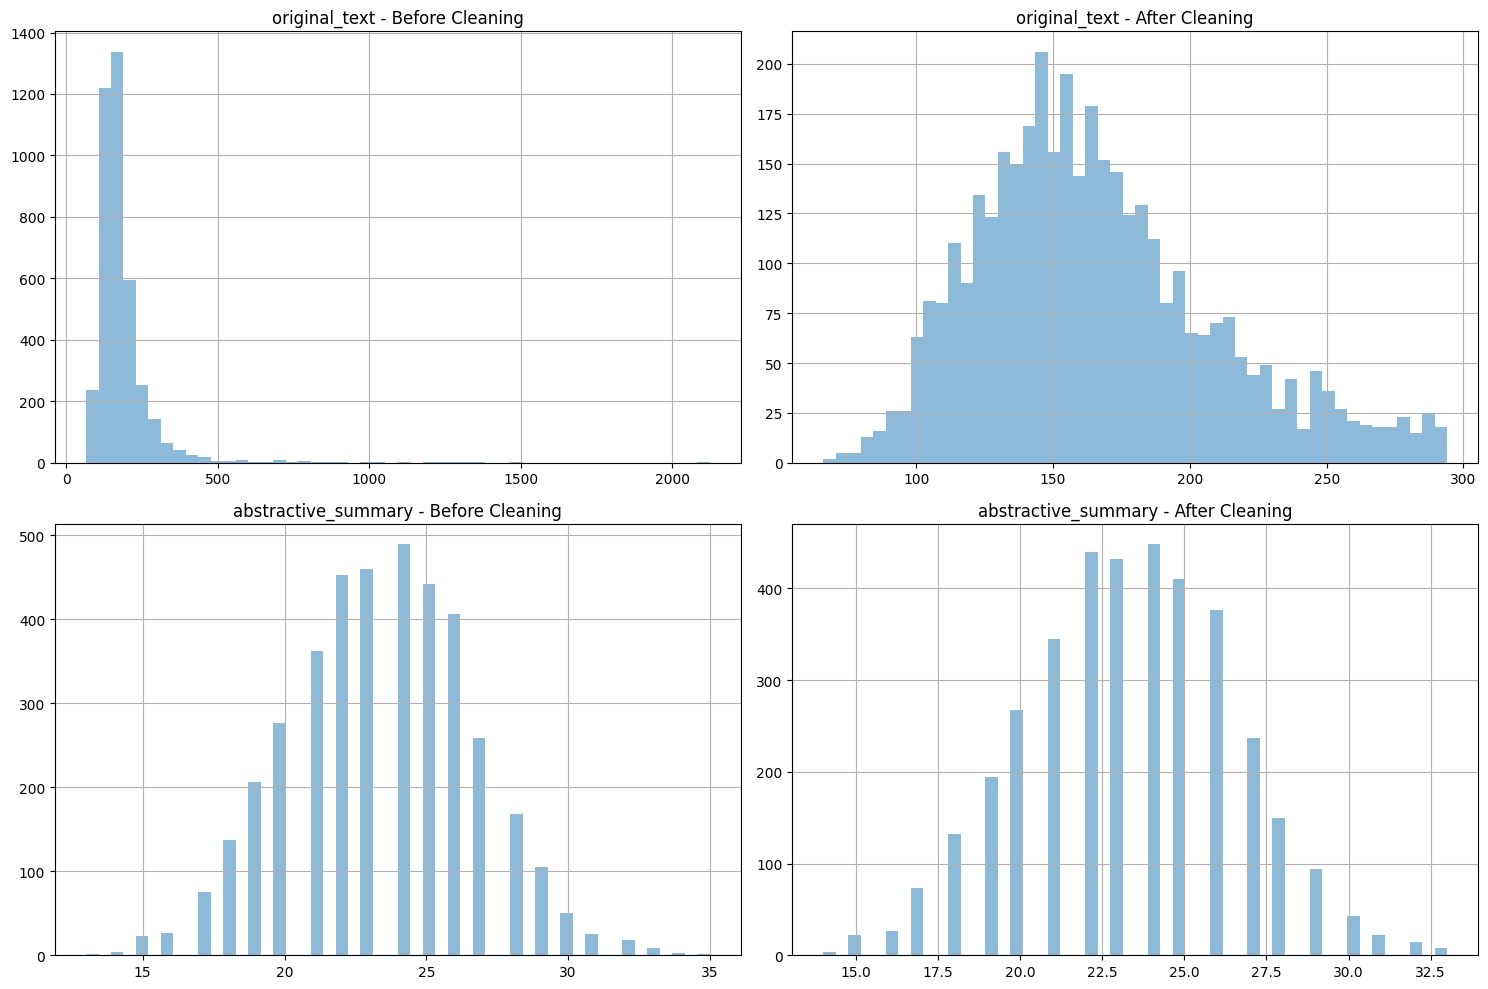

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def find_and_remove_outliers(df, columns):
    """
    Find and remove outliers from specified columns based on word count

    Parameters:
    df (pandas.DataFrame): Input dataframe
    columns (list): List of column names to check for outliers

    Returns:
    tuple: (cleaned_df, outliers_df)
    """
    # Add word count columns
    for col in columns:
        df[f'{col}_words'] = df[col].apply(count_words)

    # Calculate bounds for each column
    bounds = {}
    for col in columns:
        bounds[col] = calculate_outlier_bounds(df[f'{col}_words'])

    # Create mask for valid rows
    mask = pd.Series(True, index=df.index)
    for col in columns:
        lower, upper = bounds[col]
        mask &= df[f'{col}_words'].between(lower, upper)

    # Split into clean data and outliers
    clean_df = df[mask].copy()
    outliers_df = df[~mask].copy()

    # Remove temporary word count columns
    for col in columns:
        clean_df.drop(f'{col}_words', axis=1, inplace=True)
        outliers_df.drop(f'{col}_words', axis=1, inplace=True)

    return clean_df, outliers_df

# Penggunaan
columns_to_check = ['original_text', 'abstractive_summary']
clean_sample_test_df, outliers = find_and_remove_outliers(sample_test_df, columns_to_check)

# Print results
print(f"Original shape: {sample_test_df.shape}")
print(f"Shape after removing outliers: {clean_sample_test_df.shape}")
print(f"Number of outliers removed: {len(outliers)}")

# Optional: Visualisasi distribusi sebelum dan sesudah
def plot_word_distributions(original_df, cleaned_df, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(15, 5*len(columns)))

    for i, col in enumerate(columns):
        # Before cleaning
        original_df[col].apply(count_words).hist(
            ax=axes[i,0], bins=50, alpha=0.5
        )
        axes[i,0].set_title(f'{col} - Before Cleaning')

        # After cleaning
        cleaned_df[col].apply(count_words).hist(
            ax=axes[i,1], bins=50, alpha=0.5
        )
        axes[i,1].set_title(f'{col} - After Cleaning')

    plt.tight_layout()
    plt.show()

# Plot distributions
plot_word_distributions(sample_test_df, clean_sample_test_df, columns_to_check)

In [ ]:
from google.colab import files

clean_sample_test_df.to_csv('test_df.csv', encoding = 'utf-8-sig')
files.download('test_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>